# Earnings Calendar Source Analysis

Compare earnings dates from Nasdaq, FMP, and Yahoo Finance to identify discrepancies.

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import sys
sys.path.insert(0, '..')

from trading.earnings.logging import TradeLogger
from trading.earnings.screener import fetch_all_earnings_sources

DB_PATH = '../data/earnings_trades.db'
logger = TradeLogger(DB_PATH)

In [15]:
# Fetch from all sources and log to DB
# Note: Yahoo now uses earningsTimestamp which provides both date AND timing (BMO/AMC)
DAYS_AHEAD = 30  # Fetch a month of upcoming earnings

print(f"Fetching earnings from all sources ({DAYS_AHEAD} days ahead)...")
results = fetch_all_earnings_sources(days_ahead=DAYS_AHEAD, trade_logger=logger)

for source, events in results.items():
    timing_counts = {}
    for e in events:
        timing_counts[e.timing] = timing_counts.get(e.timing, 0) + 1
    print(f"{source}: {len(events)} events - timing: {timing_counts}")

Fetching earnings from all sources (30 days ahead)...
nasdaq: 1536 events - timing: {'BMO': 248, 'unknown': 1082, 'AMC': 206}
fmp: 3095 events - timing: {'unknown': 3095}
yahoo: 34 events - timing: {'BMO': 23, 'AMC': 11}


In [16]:
# Load earnings calendar from DB
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("""
    SELECT symbol, earnings_date, timing, eps_estimate, source, fetched_at
    FROM earnings_calendar
    ORDER BY earnings_date, symbol, source
""", conn)
conn.close()

print(f"Total records: {len(df)}")
print(f"\nRecords by source:")
print(df.groupby('source').size())
df.head(10)

Total records: 4838

Records by source:
source
fmp       3257
nasdaq    1536
yahoo       45
dtype: int64


,symbol,earnings_date,timing,eps_estimate,source,fetched_at
0,ABCFF,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:02.254864
1,ADAPY,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:02.011634
2,AKEMF,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:01.982166
3,ALTS,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:01.972817
4,AMLI,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:01.661808
5,ASRE,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:02.333649
6,ATON,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:02.126482
7,AURWF,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:01.881297
8,AUXXF,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:02.002269
9,AVCVF,2026-01-12,unknown,NaN,fmp,2026-01-12T10:11:01.748332


In [17]:
df[df.symbol=='CNXC']

,symbol,earnings_date,timing,eps_estimate,source,fetched_at
110,CNXC,2026-01-13,unknown,2.93,fmp,2026-01-12T10:11:01.379075
111,CNXC,2026-01-13,BMO,2.50,nasdaq,2026-01-12T10:18:15.622992
112,CNXC,2026-01-13,BMO,2.91,yahoo,2026-01-12T10:19:06.287753


In [18]:
x = df[(df.earnings_date=='2026-01-12') & (df.source=='yahoo')]
x

,symbol,earnings_date,timing,eps_estimate,source,fetched_at
79,SIFY,2026-01-12,BMO,0.00,yahoo,2026-01-12T10:19:06.195526
82,SOTK,2026-01-12,unknown,0.02,yahoo,2026-01-12T02:31:04.911768
97,VMAR,2026-01-12,unknown,NaN,yahoo,2026-01-12T02:31:05.088297


In [19]:
# Pivot to compare sources side-by-side
# Group by symbol and get dates from each source
pivot = df.pivot_table(
    index='symbol',
    columns='source',
    values='earnings_date',
    aggfunc='first'
).reset_index()

print(f"Symbols with data: {len(pivot)}")
pivot.head(20)

Symbols with data: 3272


source,symbol,fmp,nasdaq,yahoo
0,AA,2026-01-22,2026-01-22,NaN
1,AAFRF,2026-01-30,NaN,NaN
2,AAGFF,2026-01-22,NaN,NaN
3,AAL,2026-01-22,2026-01-22,NaN
4,AAMI,2026-02-05,2026-02-05,NaN
5,AAPL,2026-01-29,2026-01-29,NaN
6,AARTY,2026-01-28,NaN,NaN
7,AAT,2026-02-03,2026-02-03,NaN
8,AAVMY,2026-02-11,NaN,NaN
9,AB,2026-02-05,2026-02-05,NaN


In [20]:
# Find discrepancies - symbols where sources disagree on date
def check_discrepancy(row):
    dates = [row.get('nasdaq'), row.get('fmp'), row.get('yahoo')]
    dates = [d for d in dates if pd.notna(d)]
    if len(dates) <= 1:
        return 'single_source'
    return 'mismatch' if len(set(dates)) > 1 else 'agree'

pivot['status'] = pivot.apply(check_discrepancy, axis=1)

print("Agreement status:")
print(pivot['status'].value_counts())

# Show mismatches
mismatches = pivot[pivot['status'] == 'mismatch'].copy()
print(f"\n=== DATE MISMATCHES ({len(mismatches)}) ===")
mismatches

Agreement status:
status
single_source    1753
agree            1487
mismatch           32
Name: count, dtype: int64

=== DATE MISMATCHES (32) ===


source,symbol,fmp,nasdaq,yahoo,status
114,ALAB,2026-02-10,2026-02-09,NaN,mismatch
194,APTV,2026-02-05,2026-02-02,NaN,mismatch
295,AXS,2026-01-28,2026-02-04,NaN,mismatch
325,BBT,2026-01-28,2026-01-29,NaN,mismatch
525,CASH,2026-01-22,2026-01-20,NaN,mismatch
528,CATY,2026-01-22,2026-01-28,NaN,mismatch
543,CBT,2026-02-03,2026-02-02,NaN,mismatch
822,DGX,2026-02-10,2026-01-29,NaN,mismatch
909,EGP,2026-02-04,2026-02-05,NaN,mismatch
1044,FFBC,2026-01-22,2026-01-28,NaN,mismatch


In [21]:
# Timing analysis - compare BMO/AMC across sources
# Note: Yahoo now provides timing via earningsTimestamp (BMO if hour < 10, AMC if hour >= 16)
timing_pivot = df.pivot_table(
    index='symbol',
    columns='source',
    values='timing',
    aggfunc='first'
).reset_index()

def check_timing_discrepancy(row):
    timings = [row.get('nasdaq'), row.get('fmp'), row.get('yahoo')]
    # Filter out None and 'unknown'
    known = [t for t in timings if pd.notna(t) and t != 'unknown']
    if len(known) <= 1:
        return 'insufficient'
    return 'mismatch' if len(set(known)) > 1 else 'agree'

timing_pivot['timing_status'] = timing_pivot.apply(check_timing_discrepancy, axis=1)

print("Timing agreement:")
print(timing_pivot['timing_status'].value_counts())

# Show timing mismatches
timing_mismatches = timing_pivot[timing_pivot['timing_status'] == 'mismatch']
print(f"\n=== TIMING MISMATCHES ({len(timing_mismatches)}) ===")
if len(timing_mismatches) > 0:
    print(timing_mismatches)
else:
    print("No timing mismatches found")

Timing agreement:
timing_status
insufficient    3242
agree             30
Name: count, dtype: int64

=== TIMING MISMATCHES (0) ===
No timing mismatches found


In [22]:
# Timing fill rate analysis
# How much does Yahoo help fill in unknown timing from Nasdaq?

nasdaq_df = df[df['source'] == 'nasdaq']
yahoo_df = df[df['source'] == 'yahoo']

nasdaq_unknown = nasdaq_df[nasdaq_df['timing'] == 'unknown']['symbol'].tolist()
print(f"Nasdaq symbols with unknown timing: {len(nasdaq_unknown)}")

# Check how many Yahoo can fill
yahoo_with_timing = yahoo_df[yahoo_df['timing'].isin(['BMO', 'AMC'])]
yahoo_can_fill = yahoo_with_timing[yahoo_with_timing['symbol'].isin(nasdaq_unknown)]

print(f"Yahoo can fill timing for: {len(yahoo_can_fill)} of {len(nasdaq_unknown)}")
if len(nasdaq_unknown) > 0:
    fill_rate = len(yahoo_can_fill) / len(nasdaq_unknown) * 100
    print(f"Fill rate: {fill_rate:.1f}%")

# Show which symbols Yahoo can fill
if len(yahoo_can_fill) > 0:
    print("\nSymbols where Yahoo provides timing for Nasdaq unknown:")
    for _, row in yahoo_can_fill.iterrows():
        print(f"  {row['symbol']}: {row['timing']}")

Nasdaq symbols with unknown timing: 1082
Yahoo can fill timing for: 4 of 1082
Fill rate: 0.4%

Symbols where Yahoo provides timing for Nasdaq unknown:
  PKE: AMC
  INFY: BMO
  TSM: BMO
  WAFD: AMC


In [23]:
# Source coverage analysis
sources = ['nasdaq', 'fmp', 'yahoo']
coverage = {}

for src in sources:
    if src in pivot.columns:
        has_data = pivot[src].notna()
        coverage[src] = has_data.sum()
    else:
        coverage[src] = 0

print("Source coverage (unique symbols):")
for src, count in coverage.items():
    print(f"  {src}: {count}")

# Venn-style overlap (only if columns exist)
def safe_col(col):
    return pivot[col].notna() if col in pivot.columns else pd.Series([False] * len(pivot))

all_three = (safe_col('nasdaq') & safe_col('fmp') & safe_col('yahoo')).sum()
nasdaq_fmp = (safe_col('nasdaq') & safe_col('fmp')).sum()
nasdaq_yahoo = (safe_col('nasdaq') & safe_col('yahoo')).sum()
fmp_yahoo = (safe_col('fmp') & safe_col('yahoo')).sum()

print(f"\nOverlap:")
print(f"  All three sources: {all_three}")
print(f"  Nasdaq + FMP: {nasdaq_fmp}")
print(f"  Nasdaq + Yahoo: {nasdaq_yahoo}")
print(f"  FMP + Yahoo: {fmp_yahoo}")

Source coverage (unique symbols):
  nasdaq: 1536
  fmp: 3255
  yahoo: 45

Overlap:
  All three sources: 45
  Nasdaq + FMP: 1519
  Nasdaq + Yahoo: 45
  FMP + Yahoo: 45


In [24]:
# Check specific symbol (e.g., BK)
symbol_to_check = 'BK'
symbol_data = df[df['symbol'] == symbol_to_check]

if len(symbol_data) > 0:
    print(f"=== {symbol_to_check} Earnings Data ===")
    print(symbol_data[['source', 'earnings_date', 'timing', 'eps_estimate', 'fetched_at']].to_string(index=False))
else:
    print(f"No data found for {symbol_to_check}")

=== BK Earnings Data ===
source earnings_date  timing  eps_estimate                 fetched_at
   fmp    2026-01-13 unknown       1.97000 2026-01-12T10:11:01.323417
nasdaq    2026-01-13     BMO       1.97000 2026-01-12T10:18:15.603101
 yahoo    2026-01-13     BMO       1.98273 2026-01-12T10:19:06.306250


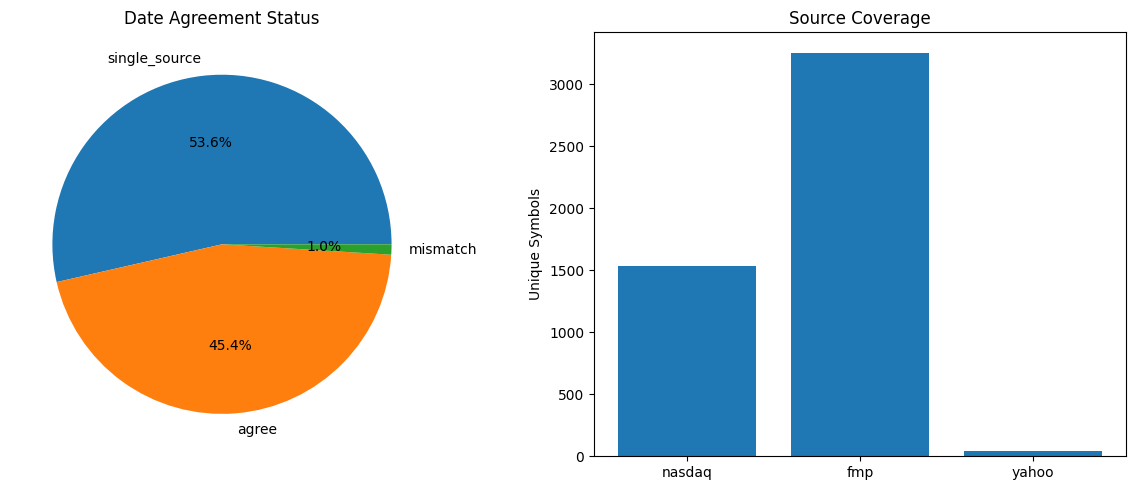

In [25]:
# Visualization: Agreement rates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Date agreement
status_counts = pivot['status'].value_counts()
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
axes[0].set_title('Date Agreement Status')

# Source coverage bar chart
axes[1].bar(coverage.keys(), coverage.values())
axes[1].set_ylabel('Unique Symbols')
axes[1].set_title('Source Coverage')

plt.tight_layout()
plt.savefig('../data/earnings_calendar_coverage.png', dpi=100)
plt.show()

In [26]:
# Recommendations
print("=== RECOMMENDATIONS ===")
print()

total_symbols = len(pivot)
mismatches_count = len(mismatches)
mismatch_rate = mismatches_count / total_symbols * 100 if total_symbols > 0 else 0

print(f"Date mismatch rate: {mismatch_rate:.1f}%")
print()

if mismatch_rate > 5:
    print("WARNING: High mismatch rate detected.")
    print("Consider requiring 2-of-3 source agreement before trading.")
else:
    print("Mismatch rate is acceptable.")
    print("Nasdaq can be used as primary source.")

print()
print("Symbols with date mismatches should be flagged for LLM verification.")

=== RECOMMENDATIONS ===

Date mismatch rate: 1.0%

Mismatch rate is acceptable.
Nasdaq can be used as primary source.

Symbols with date mismatches should be flagged for LLM verification.
